In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (3D projection side effect)


In [91]:
CSV_PATH = '../options_SPY_calls.csv'
df = pd.read_csv(CSV_PATH)
required_cols = {'S0', 'K', 'T', 'iv'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f'Missing columns in CSV: {missing}')

S0 = float(df['S0'].iloc[0])
print(f'Loaded {CSV_PATH} with {len(df)} rows | S0 = {S0:.4f}')
df['T'] = df['T'].round(2)
df = df.drop_duplicates(subset=['K', 'T']).reset_index(drop=True)
display(df.head())


Loaded ../options_SPY_calls.csv with 2828 rows | S0 = 673.6400


,S0,K,C_mkt,T,type,iv
0,673.640015,530.0,156.60,0.0,C,1.756837
1,673.640015,540.0,126.43,0.0,C,1.689455
2,673.640015,545.0,134.20,0.0,C,1.634279
3,673.640015,555.0,116.71,0.0,C,1.504885
4,673.640015,560.0,104.69,0.0,C,1.513186


In [92]:
num_points = 200
K_grid = np.linspace(S0 - 100.0, S0 + 100.0, num_points)
T_grid = np.linspace(0.0, 2.0, num_points)
KK, TT = np.meshgrid(K_grid, T_grid)
print(f'Grid shapes -> K: {K_grid.shape}, T: {T_grid.shape}')


Grid shapes -> K: (200,), T: (200,)


In [93]:
k_vals = df['K'].to_numpy()
t_vals = df['T'].to_numpy()
iv_vals = df['iv'].to_numpy()

k_idx = np.abs(k_vals[:, None] - K_grid).argmin(axis=1)
t_idx = np.abs(t_vals[:, None] - T_grid).argmin(axis=1)
df['K_bin'] = K_grid[k_idx]
df['T_bin'] = T_grid[t_idx]

grouped = df.groupby(['T_bin', 'K_bin'], as_index=False)['iv'].mean()
IV_surface = np.full((len(T_grid), len(K_grid)), np.nan)
k_pos = {value: idx for idx, value in enumerate(K_grid)}
t_pos = {value: idx for idx, value in enumerate(T_grid)}
for row in grouped.itertuples(index=False):
    i = t_pos[row.T_bin]
    j = k_pos[row.K_bin]
    IV_surface[i, j] = row.iv

missing = np.isnan(IV_surface).sum()
print(f'Filled {grouped.shape[0]} grid cells | Missing cells: {missing}')
IV_masked = np.ma.array(IV_surface, mask=np.isnan(IV_surface))


Filled 2105 grid cells | Missing cells: 37895


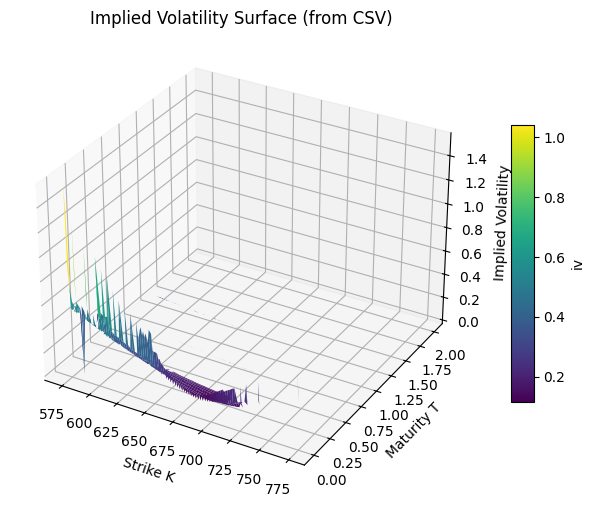

In [94]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(KK, TT, IV_masked, cmap='viridis', rstride=2, cstride=2, linewidth=0, antialiased=True)
ax.set_xlabel('Strike K')
ax.set_ylabel('Maturity T')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface (from CSV)')
fig.colorbar(surf, shrink=0.6, aspect=12, label='iv')
plt.show()
